### Import Required Libraries

In [0]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd drive/'My Drive'/TEXT/Machine_learning_ES

/content/drive/My Drive/TEXT/Machine_learning_ES


### Read Data

Our data is a text file of English-Spanish sentence pairs. First we will read the file using the function defined below.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-Spanish pairs separated by '\n' and then split these pairs into English sentences and Spanish sentences.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [0]:
!ls

de_eng	     LAB_TEXT_MachineTranslation_DE_EN.ipynb  README.md  spa-eng.zip
deu-eng.zip  model.h1.24_jan_19			      spa-eng


__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [0]:
data = read_text("spa-eng/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [0]:
spa_eng = spa_eng[:50,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [0]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ['Go.', 'Váyase.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)'],
       ['Hi.', 'Hola.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)'],
       ['Run!', '¡Corre!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)'],
       ['Run!', '¡Corran!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)'],
       ['Run!', '¡Corra!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)'],
       ['Run!', '¡Corred!',
        'CC-BY 2.0 (Fr

We will get rid of the punctuation marks, and then convert the text to lower case.

In [0]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [0]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ['Go', 'Váyase',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)'],
       ['Hi', 'Hola',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)'],
       ['Run', '¡Corre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)'],
       ['Run', '¡Corran',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)'],
       ['Run', '¡Corra',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)'],
       ['Run', '¡Corred',
        'CC-BY 2.0 (France) Attribution:

In [0]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [0]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ['go', 'váyase',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)'],
       ['hi', 'hola',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)'],
       ['run', '¡corre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)'],
       ['run', '¡corran',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)'],
       ['run', '¡corra',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)'],
       ['run', '¡corred',
        'CC-BY 2.0 (France) Attribution:

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and Spanish, respectively.

In [0]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [0]:
 spa_eng[:,1]

array(['ve', 'vete', 'vaya', 'váyase', 'hola', '¡corre', '¡corran',
       '¡corra', '¡corred', 'corred', '¿quién', '¡órale', '¡fuego',
       '¡incendio', '¡disparad', '¡ayuda', '¡socorro ¡auxilio',
       '¡auxilio', '¡salta', 'salte', '¡parad', '¡para', '¡pare',
       '¡espera', 'esperen', 'continúa', 'continúe', 'hola', 'corrí',
       'corría', 'lo intento', '¡he ganado', '¡oh no',
       'tomátelo con soda', '¡fuego', '¡disparad', '¡disparen',
       '¡dispara', '¡dispará', '¡dispare', 'sonríe', '¡al ataque',
       '¡atacad', '¡ataque', '¡ataquen', '¡ataca', 'levanta',
       've ahora mismo', 'id ahora mismo', 'vaya ahora mismo'],
      dtype='<U332')

In [0]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

    eng  spa
0     1    1
1     1    1
2     1    1
3     1    1
4     1    1
5     1    1
6     1    1
7     1    1
8     1    1
9     1    1
10    1    1
11    1    1
12    1    1
13    1    1
14    1    1
15    1    1
16    1    2
17    1    1
18    1    1
19    1    1
20    1    1
21    1    1
22    1    1
23    1    1
24    1    1
25    2    1
26    2    1
27    1    1
28    2    1
29    2    1
30    2    2
31    2    2
32    2    2
33    1    3
34    1    1
35    1    1
36    1    1
37    1    1
38    1    1
39    1    1
40    1    1
41    1    2
42    1    1
43    1    1
44    1    1
45    1    1
46    2    1
47    2    3
48    2    3
49    2    3
2
3


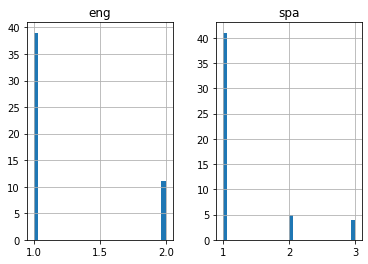

In [0]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [0]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 26


In [0]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 54


In [0]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 2), ('vete', 1), ('vaya', 2), ('váyase', 1), ('hola', 2), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 1), ('¡órale', 1), ('¡fuego', 2), ('¡incendio', 1), ('¡disparad', 2), ('¡ayuda', 1), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 1), ('¡parad', 1), ('¡para', 1), ('¡pare', 1), ('¡espera', 1), ('esperen', 1), ('continúa', 1), ('continúe', 1), ('corrí', 1), ('corría', 1), ('lo', 1), ('intento', 1), ('¡he', 1), ('ganado', 1), ('¡oh', 1), ('no', 1), ('tomátelo', 1), ('con', 1), ('soda', 1), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 1), ('¡al', 1), ('ataque', 1), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 1), ('ahora', 3), ('mismo', 3), ('id', 1)])


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode Spanish sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [0]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(spa_tokenizer, spa_length, train[:, 0])

[[ 8  0  0  0  0  0  0  0]
 [43  0  0  0  0  0  0  0]
 [42  0  0  0  0  0  0  0]
 [19  0  0  0  0  0  0  0]
 [34 35  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0]
 [29  0  0  0  0  0  0  0]
 [15  0  0  0  0  0  0  0]
 [38 39 40  0  0  0  0  0]
 [ 3  1  2  0  0  0  0  0]
 [23  0  0  0  0  0  0  0]
 [20  8  0  0  0  0  0  0]
 [27  0  0  0  0  0  0  0]
 [48  0  0  0  0  0  0  0]
 [36 37  0  0  0  0  0  0]
 [ 7  0  0  0  0  0  0  0]
 [26  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0]
 [32 33  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0]
 [50  0  0  0  0  0  0  0]
 [44  0  0  0  0  0  0  0]
 [21  0  0  0  0  0  0  0]
 [45  0  0  0  0  0  0  0]
 [49  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0]
 [16  0  0  0  0  0  0  0]
 [ 4  1  2  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0]
 [28  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0]
 [25  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0]
 [51  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0]
 

In [0]:
train[:, 0]

array(['help', 'shoot', 'shoot', 'help', 'i won', 'fire', 'go on', 'run',
       'relax', 'go now', 'stop', 'help', 'wait', 'attack', 'oh no',
       'shoot', 'wait', 'go', 'i try', 'hi', 'attack', 'shoot', 'jump',
       'smile', 'attack', 'go', 'who', 'go now', 'shoot', 'go on', 'fire',
       'run', 'stop', 'fire', 'attack', 'go', 'go', 'run', 'hello', 'wow'],
      dtype='<U332')

In [0]:
print(trainX.shape)
print(trainY.shape)

(40, 8)
(40, 8)


In [0]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[30  0  0  0  0  0  0  0]
 [52  0  0  0  0  0  0  0]
 [13  0  0  0  0  0  0  0]
 [46 47  0  0  0  0  0  0]
 [41  0  0  0  0  0  0  0]
 [31  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [53  1  2  0  0  0  0  0]
 [22  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0]]
10
[[ 5 13  0  0  0  0  0  0]
 [24 25  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]
 [ 5 13  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0]
 [ 1  9  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0]]
10


In [0]:
print(testX.shape)
print(testY.shape)

(10, 8)
(10, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [0]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

54
26
8
8


In [0]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 64)
rms = optimizers.RMSprop(lr=0.1)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [0]:
!ls

de_eng	     LAB_TEXT_MachineTranslation_DE_EN.ipynb  README.md  spa-eng.zip
deu-eng.zip  model.h1.24_jan_19			      spa-eng


In [0]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=64, 
          validation_split = 0.1,
          callbacks=[checkpoint], verbose=1)



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 36 samples, validate on 4 samples
Epoch 1/30
36/36 [==============================] - 1s 18ms/step - loss: nan - accuracy: 0.0660 - val_loss: 3.2581 - val_accuracy: 1.0000

Epoch 00001: loss did not improve from inf
Epoch 2/30
36/36 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9965 - val_loss: 3.2581 - val_accuracy: 1.0000

Epoch 00002: loss did not improve from inf
Epoch 3/30
36/36 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9965 - val_loss: 3.2581 - val_accuracy: 1.0000

Epoch 00003: loss did not improve from inf
Epoch 4/30
36/36 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9965 - val_loss: 3.2581 - val_accuracy: 1.0000

Epoch 00004: loss did not improve from inf
Epoch 5/30
36/36 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9965 - val_loss: 3.2581 - val_accuracy: 1.0000

Epoch 00005: loss did not improve from inf
Epoch 6/30
36/36 [==============================] -

Let's compare the training loss and the validation loss.

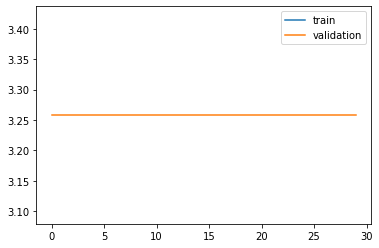

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [0]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [0]:
pred_df.head(15)

,actual,predicted
0,i ran,
1,get up,
2,run,
3,attack,
4,shoot,
5,i ran,
6,stop,
7,go now,
8,jump,
9,run,


In [0]:
pred_df.tail(15)

,actual,predicted
0,i ran,
1,get up,
2,run,
3,attack,
4,shoot,
5,i ran,
6,stop,
7,go now,
8,jump,
9,run,


In [0]:
pred_df.tail(15)

,actual,predicted
0,i ran,
1,get up,
2,run,
3,attack,
4,shoot,
5,i ran,
6,stop,
7,go now,
8,jump,
9,run,


In [0]:
pred_df.sample(15)

ValueError: ignored